# Deep Learning Flow

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 변하지 않는 Deep Learning Flow


|data|Preprocess|Model|Evaluation|
|:------|:------:|------:|------:|
||데이터검증|modeling|학습과정 추적|
||전처리|학습로직|후처리|
||데이터 증강||모델검증|

---
## 1. Data 가져오기
#### tensorflow에서 제공하는 MNIST예제
- 데이터 shape, dtype 확인하기

In [2]:
(train_x, train_y), (test_x, test_y)  = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
print(train_x.shape)
print(test_x.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
print(train_y.shape)
print(test_y.shape)

(60000,)
(10000,)


In [5]:
print(train_x.dtype)
print(test_x.dtype)

print(train_y.dtype)
print(test_y.dtype)

uint8
uint8
uint8
uint8


### (1) 데이터 하나만 뽑아서 시각화로 확인

In [24]:
image = train_x[55]
image.shape

(28, 28)

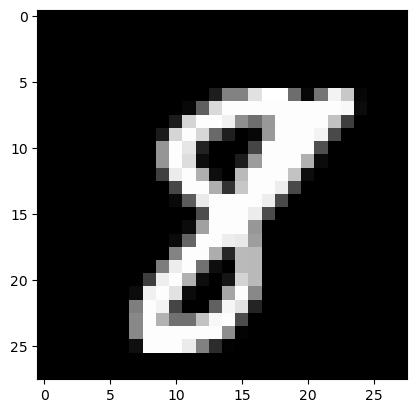

In [25]:
plt.imshow(image, 'gray')
plt.show()

### (2) 각 숫자의 그림이 몇 개씩 들어가있는지 확인 (시각화)

In [17]:
print("0: ", list(train_y).count(0))
print("1: ", list(train_y).count(1))
print("2: ", list(train_y).count(2))
print("3: ", list(train_y).count(3))
print("4: ", list(train_y).count(4))
print("5: ", list(train_y).count(5))
print("6: ", list(train_y).count(6))
print("7: ", list(train_y).count(7))
print("8: ", list(train_y).count(8))
print("9: ", list(train_y).count(9))

0:  5923
1:  6742
2:  5958
3:  6131
4:  5842
5:  5421
6:  5918
7:  6265
8:  5851
9:  5949


In [18]:
y_unique, y_counts = np.unique(train_y, return_counts=True)
print(y_unique, y_counts)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


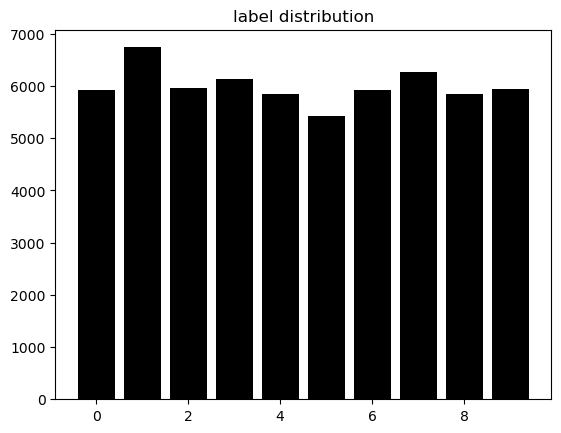

In [19]:
df_view = pd.DataFrame(data={"count" : y_counts}, index=y_unique)
df_view.sort_values("count", ascending=False)
plt.bar(x=y_unique, height=y_counts, color="black")
plt.title("label distribution")
plt.show()

### (3) 이미지를 시계 반대 방향으로 90도 회전하고 상하 반전 시키기

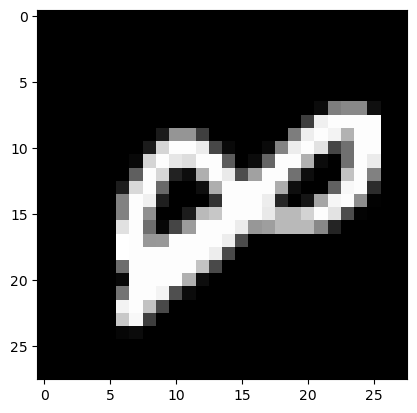

In [22]:
image = train_x[55]
image = tf.constant(image)

plt.imshow((tf.transpose(image)), 'gray')
plt.show()

---
## 2. Preprocessing
- 데이터 검증
- 전처리
- 데이터 증강

### (1) 데이터 검증
 - 데이터 중에 학습에 포함 되면 안되는 것이 있는가? ex> 개인정보가 들어있는 데이터, 테스트용 데이터에 들어있는것, 중복되는 데이터
 - 학습 의도와 다른 데이터가 있는가? ex> 얼굴을 학습하는데 발 사진이 들어가있진 않은지(가끔은 의도하고 일부러 집어넣는 경우도 있음)
 - 라벨이 잘못된 데이터가 있는가? ex> 7인데 1로 라벨링, 고양이 인데 강아지로 라벨링 
 -  train, test 파일을 동일한 로직으로 검증해야 하기 때문에 함수나 클래스로 만들어서 검증하는게 좋다
 

In [26]:
def validate_pixel_scale(x):
    return 255 >= x.max() and 0 <= x.min()

In [31]:
validated_train_x = np.array([x for x in train_x if validate_pixel_scale(x)])

validated_train_y = np.array([y for x, y in zip(train_x, train_y) if validate_pixel_scale(x)])

In [28]:
print(validated_train_x.shape)
print(validated_train_y.shape)

(60000, 28, 28)
(60000,)


### (2) 전처리
 - 입력하기 전에 모델링에 적합하게 처리! 
 - 대표적으로 Scaling, Resizing(Flattening), label encoding 등이 있다. 
 - dtype, shape 항상 체크!!

#### Scaling

In [29]:
def scale(x):
    return (x / 255.0).astype(np.float32)

- 픽셀값이 1-255값을 가지니까 255로 나눠서 0~1 사이 값으로 scaling

In [35]:
# 함수가 잘 만들어졌는지 하나의 데이터로 먼저 확인

sample = scale(validated_train_x[777])
print(sample.max())
print(sample.min())

1.0
0.0


In [33]:
scaled_train_x = np.array([scale(x) for x in validated_train_x])

#### Flattening

 - 이번에 사용할 모델은 기본적인 Feed-Forward Neural Network
 - 1차원 벡터가 Input의 샘플 하나가 된다. (2차원 텐서라는 말)

In [36]:
flattend_train_x = scaled_train_x.reshape((60000, -1))
flattend_train_x.shape  # 잘 됐는지 확인

(60000, 784)

#### Label encoding

 - One-Hot encoding
 - `tf.keras.utils.to_categorical` 사용! 

In [32]:
tf.keras.utils.to_categorical(5, num_classes=10)  # 10개 클래스 중에 5번째 클래스

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [37]:
ohe_train_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_train_y])
ohe_train_y.shape  # 잘 됐는지 확인

(60000, 10)

### 보통은 큰 작업을 하나의 클래스로 만들어서 관리

In [41]:
class DataLoader():
    def __init__(self):
        (self.train_x, self.train_y), (self.test_x, self.test_y) = tf.keras.datasets.mnist.load_data()
        
    def validate_pixel_scale(self, x):
        return 255 >= x.max() and 0 <= x.min()
    
    def scale(self, x):
        return (x / 255.0).astype(np.float32)
    
    def preprocess_dataset(self, dataset):
        feature, target = dataset
        
        validated_x = np.array([x for x in feature if self.validate_pixel_scale(x)])
        validated_y = np.array([y for x, y in zip(feature, target) if self.validate_pixel_scale(x)])
        
        #scale
        scaled_x = np.array([self.scale(x) for x in validated_x])
        
        #flatten
        flatten_x = scaled_x.reshape((scaled_x.shape[0], -1))
        
        # label encoding
        ohe_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_y])
        
        return flatten_x, ohe_y
    
    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))
    
    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [42]:
mnist_loader = DataLoader()

In [43]:
train_x, train_y = mnist_loader.get_train_dataset()
test_x, test_y = mnist_loader.get_test_dataset()

In [44]:
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

(60000, 784) float32
(60000, 10) float32


In [45]:
print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(10000, 784) float32
(10000, 10) float32


---
## 3. Modeling
- 모델 정의
- 학습 로직 : 비용함수, 학습 파라미터 세팅
- 학습

### (1) 모델 정의

In [46]:
from tensorflow.keras.layers import Dense, Activation

In [47]:
model = tf.keras.Sequential()

In [49]:
model.add(Dense(15, input_dim=784))
model.add(Activation("sigmoid"))
model.add(Dense(10))
model.add(Activation("softmax"))

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 activation (Activation)     (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


### (2) 학습 로직

In [51]:
opt = tf.keras.optimizers.SGD(0.03) # 0.03 = lr
loss = tf.keras.losses.categorical_crossentropy

In [52]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

### (3) 학습 실행

In [58]:
hist = model.fit(train_x, train_y, epochs=10, batch_size=256)

Epoch 1/10
235/235 [==============================] - 1s 3ms/step - loss: 0.2720 - accuracy: 0.9251
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 0.2707 - accuracy: 0.9254
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 0.2695 - accuracy: 0.9257
Epoch 4/10
235/235 [==============================] - 1s 2ms/step - loss: 0.2684 - accuracy: 0.9258
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 0.2672 - accuracy: 0.9262
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 0.2661 - accuracy: 0.9266
Epoch 7/10
235/235 [==============================] - 1s 2ms/step - loss: 0.2649 - accuracy: 0.9268
Epoch 8/10
235/235 [==============================] - 1s 2ms/step - loss: 0.2638 - accuracy: 0.9272
Epoch 9/10
235/235 [==============================] - 1s 2ms/step - loss: 0.2628 - accuracy: 0.9272
Epoch 10/10
235/235 [==============================] - 1s 2ms/step - loss: 0.2617 - accuracy: 0.9273

In [59]:
hist.history

{'loss': [0.27200818061828613,
  0.27074989676475525,
  0.26953285932540894,
  0.2683549225330353,
  0.26720958948135376,
  0.26607051491737366,
  0.2648792266845703,
  0.26384657621383667,
  0.26281508803367615,
  0.26172399520874023],
 'accuracy': [0.9251499772071838,
  0.9253833293914795,
  0.9257333278656006,
  0.9258000254631042,
  0.9261833429336548,
  0.926633358001709,
  0.9267666935920715,
  0.9272000193595886,
  0.9271666407585144,
  0.9272500276565552]}

---
## 4. Evaluation 
- 학습 과정 추적 
- Test / 모델 검증
- 후처리

### (1) 학습 과정 추적

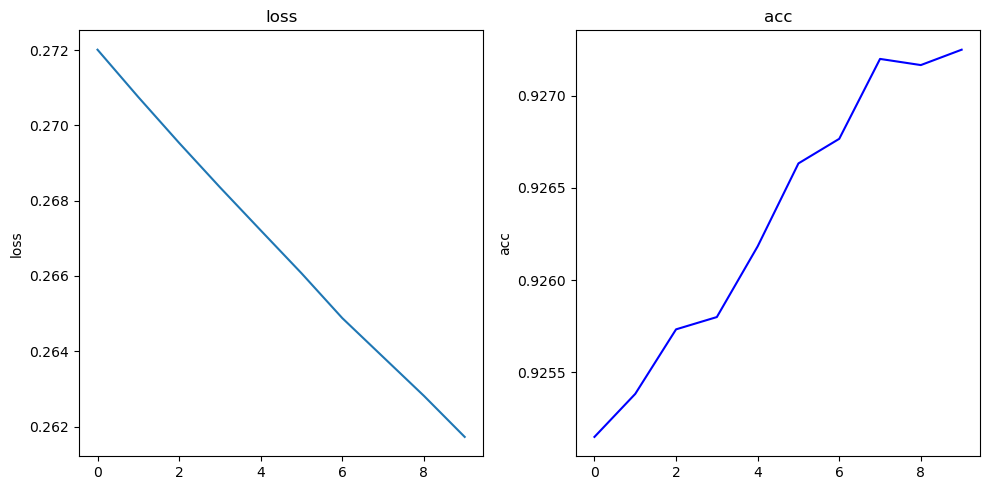

In [60]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.ylabel("loss")
plt.subplot(122)
plt.plot(hist.history['accuracy'], 'b-')
plt.title("acc")
plt.ylabel("acc")
plt.tight_layout()
plt.show()

### (2) 모델 검증

In [62]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 1s 2ms/step - loss: 0.2614 - accuracy: 0.9288


[0.2614372968673706, 0.9287999868392944]

### (3) 후처리

In [63]:
pred = model.predict(test_x[:1])
pred.argmax()

1/1 [==============================] - 0s 143ms/step


7

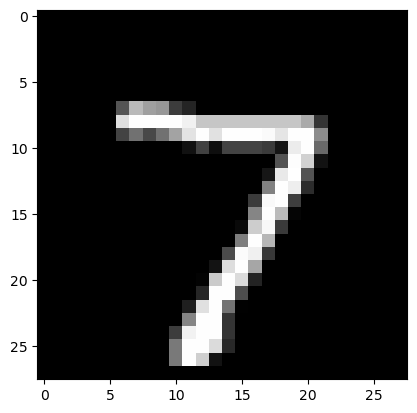

In [64]:
sample_img = test_x[0].reshape((28, 28)) * 255

plt.imshow(sample_img, 'gray')
plt.show()